# Multi-resolution deconvolution of spatial transcriptomics

In this tutorial, we through the steps of applying DestVI for deconvolution of 10x Visium spatial transcriptomics profiles using an accompanying single-cell RNA sequencing data.

**Background:**

Spatial transcriptomics technologies are currently limited, because their resolution is limited to niches (spots) of sizes well beyond that of a single cell. Although several pipelines proposed joint analysis with single-cell RNA-sequencing (scRNA-seq) to alleviate this problem they are limited to a discrete view of cell type proportion inside every spot. This limitation becomes critical in the common case where, even within a cell type, there is a continuum of cell states. We present *Deconvolution of Spatial Transcriptomics profiles using Variational Inference (DestVI)*, a probabilistic method for multi-resolution analysis for spatial transcriptomics that explicitly models continuous variation within cell types.

**Plan for this tutorial:**

1. Loading the data
1. Training the single-cell model (scLVM) to learn a basis of gene expression on the scRNA-seq data
1. Training the spatial model (stLVM) to perform the deconvolution
1. Visualize the learned cell type proportions
1. Run our automated pipeline
1. Dig into the intra cell type information
1. Run cell-type specific differential expression

```{note}
Running the following cell will install tutorial dependencies on Google Colab only. It will have no effect on environments other than Google Colab.
```

In [1]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()
#!pip install --quiet git+https://github.com/yoseflab/destvi_utils.git@main

/home/access/.conda/envs/scvi/lib/python3.12/site-packages/scvi_colab/_core.py:47: UserWarning: 
                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
  warn(


In [2]:
import tempfile

import destvi_utils
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import scvi
import seaborn as sns
import torch
from scvi.model import CondSCVI, DestVI

In [3]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Seed set to 0


Last run with scvi-tools version: 1.4.0.post1


```{note}
You can modify `save_dir` below to change where the data files for this tutorial are saved.
```

In [4]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

Let's download our data from a comparative study of murine lymph nodes, comparing wild-type with a stimulation after injection of a mycobacteria. We have at disposal a 10x Visium dataset as well as a matching scRNA-seq dataset from the same tissue.

In [5]:
url1 = "https://github.com/romain-lopez/DestVI-reproducibility/blob/master/lymph_node/deconvolution/ST-LN-compressed.h5ad?raw=true"
url2 = "https://github.com/romain-lopez/DestVI-reproducibility/blob/master/lymph_node/deconvolution/scRNA-LN-compressed.h5ad?raw=true"
out1 = "data/ST-LN-compressed.h5ad"
out2 = "data/scRNA-LN-compressed.h5ad"

## Data loading & processing

First, let's load the single-cell data. We profiled immune cells from murine lymph nodes with 10x Chromium, as a control / case study to study the immune response to exposure to a mycobacteria (refer to our paper for more info). We provide the preprocessed data from our reproducibility repository: it contains the raw counts (DestVI always takes raw counts as input).

In [6]:
sc_adata = sc.read(out2, backup_url=url2)

We clustered the single-cell data by major immune cell types. DestVI can resolve beyond discrete clusters, but need to work with an existing level of clustering. A rule of thumb to keep in mind while clsutering is that DestVI assumes only a single state from each cell type exists in each spot. For example, resting and inflammed monocytes cannot co-exist in one unique spot according to our assumption. Users may cluster their data so that this modeling assumption is as accurate as possible.

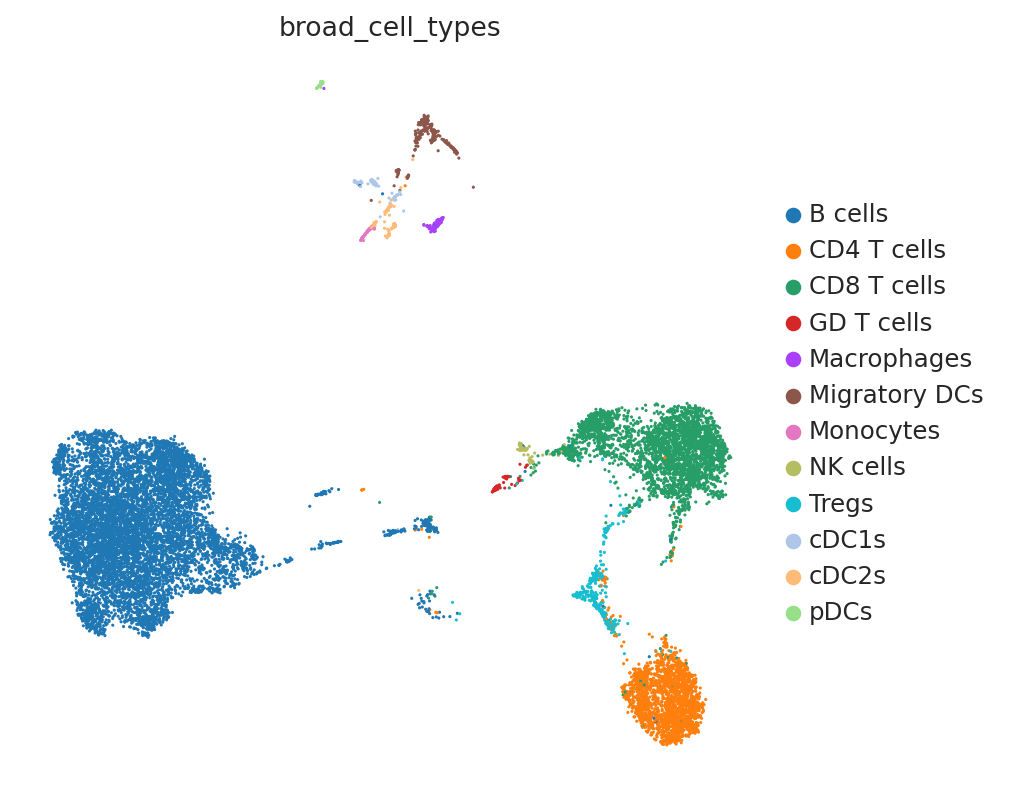

In [7]:
sc.pl.umap(sc_adata, color="broad_cell_types")

In [8]:
# let us filter some genes
G = 2000
sc.pp.filter_genes(sc_adata, min_counts=10)

sc_adata.layers["counts"] = sc_adata.X.copy()

sc.pp.highly_variable_genes(
    sc_adata, n_top_genes=G, subset=True, layer="counts", flavor="seurat_v3"
)

sc.pp.normalize_total(sc_adata, target_sum=10e4)
sc.pp.log1p(sc_adata)
sc_adata.raw = sc_adata

Now, let's load the spatial data and choose a common gene subset. Users will note that having a common gene set is a prerequisite of the method.

In [9]:
st_adata = sc.read(out1, backup_url=url1)

In [10]:
st_adata.layers["counts"] = st_adata.X.copy()
st_adata.obsm["spatial"] = st_adata.obsm["location"]

sc.pp.normalize_total(st_adata, target_sum=10e4)
sc.pp.log1p(st_adata)
st_adata.raw = st_adata

In [11]:
# filter genes to be the same on the spatial data
intersect = np.intersect1d(sc_adata.var_names, st_adata.var_names)
st_adata = st_adata[:, intersect].copy()
sc_adata = sc_adata[:, intersect].copy()
G = len(intersect)

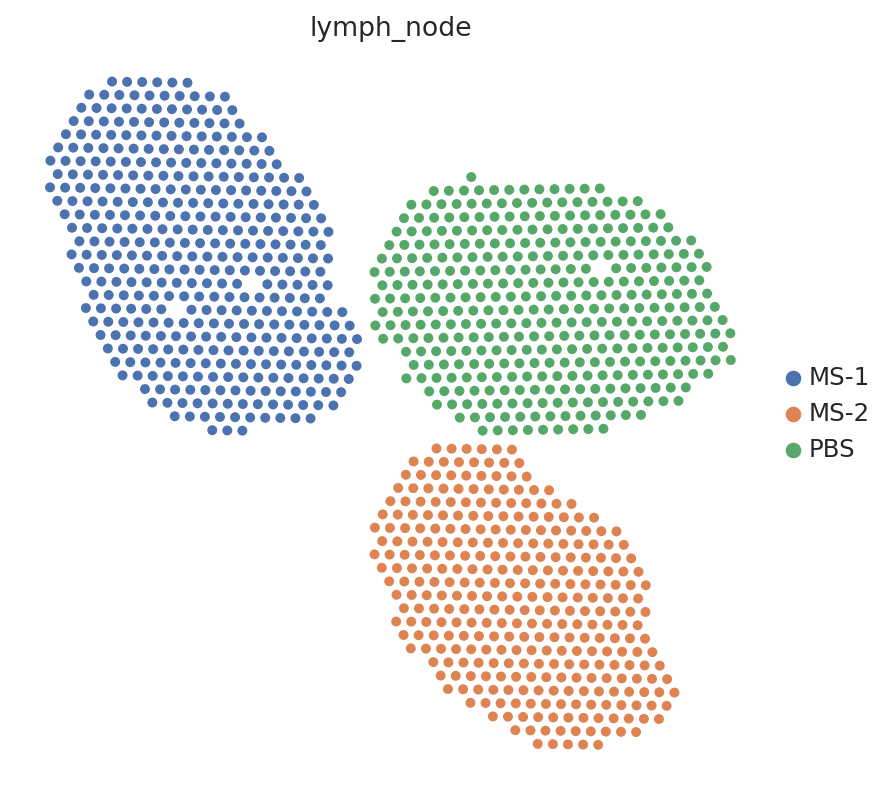

In [12]:
sc.pl.embedding(st_adata, basis="spatial", color="lymph_node", s=80)

## Fit the scLVM

In order to learn cell state specific gene expression patterns, we will fit the single-cell Latent Variable Model (scLVM) to single-cell RNA sequencing data from the same tissue.

In [13]:
sc_adata.obs.head()

n_genes         cell_types batch  n_genes_by_counts  \
AAACCCAAGCAGAAAG-1-0     1505              Tregs     0               1505   
AAACCCAAGGTCACAG-1-0     1883     Mature B cells     0               1883   
AAACCCACATCGTTCC-1-0     2080        CD8 T cells     0               2080   
AAACCCAGTCGTCTCT-1-0     1647  Cycling B/T cells     0               1647   
AAACCCAGTGTAAACA-1-0     1857     Mature B cells     0               1857   

                      total_counts  total_counts_mt  pct_counts_mt  \
AAACCCAAGCAGAAAG-1-0        5862.0            307.0       5.237121   
AAACCCAAGGTCACAG-1-0        6673.0            346.0       5.185074   
AAACCCACATCGTTCC-1-0        7764.0            438.0       5.641422   
AAACCCAGTCGTCTCT-1-0        4619.0            265.0       5.737173   
AAACCCAGTGTAAACA-1-0        5965.0            339.0       5.683152   

                     pred_cell_types  doublet_scores  doublet_predictions  \
AAACCCAAGCAGAAAG-1-0           Tregs        0.090909                  0.0   
AAACCCAAGGTCACAG-1-0        Mature B        0.116751                  0.0   
AAACCCACATCGTTCC-1-0    CD122+ CD8 T        0.041626                  0.0   
AAACCCAGTCGTCTCT-1-0        Mature B        0.098634                  0.0   
AAACCCAGTGTAAACA-1-0        Mature B        0.153374                  0.0   

                      ...  louvain_sub_0.1 louvain_sub_0.2 louvain_sub_0.3  \
AAACCCAAGCAGAAAG-1-0  ...                6               6               6   
AAACCCAAGGTCACAG-1-0  ...                0               0               0   
AAACCCACATCGTTCC-1-0  ...                1           1-3,0               1   
AAACCCAGTCGTCTCT-1-0  ...                5               5               5   
AAACCCAGTGTAAACA-1-0  ...                0               0               0   

                      louvain_sub louvain_sub_1 louvain_sub_2 louvain_sub_3  \
AAACCCAAGCAGAAAG-1-0        Tregs         Tregs           6,1           6,1   
AAACCCAAGGTCACAG-1-0    B cells,0     B cells,0             0             0   
AAACCCACATCGTTCC-1-0  CD8 T cells   CD8 T cells         1-3,0         1-3,0   
AAACCCAGTCGTCTCT-1-0    B cells,7     B cells,7             5             5   
AAACCCAGTGTAAACA-1-0    B cells,3     B cells,3             0             0   

                      SCANVI_pred_cell_types  SCVI_pred_cell_types  \
AAACCCAAGCAGAAAG-1-0                   Tregs                 Tregs   
AAACCCAAGGTCACAG-1-0       Cycling B/T cells              Mature B   
AAACCCACATCGTTCC-1-0                   CD8 T                 CD8 T   
AAACCCAGTCGTCTCT-1-0            Ifit3-high B              Mature B   
AAACCCAGTGTAAACA-1-0   B-macrophage doublets              Mature B   

                      broad_cell_types  
AAACCCAAGCAGAAAG-1-0             Tregs  
AAACCCAAGGTCACAG-1-0           B cells  
AAACCCACATCGTTCC-1-0       CD8 T cells  
AAACCCAGTCGTCTCT-1-0           B cells  
AAACCCAGTGTAAACA-1-0           B cells  

[5 rows x 31 columns]

In [14]:
CondSCVI.setup_anndata(
    sc_adata,
    layer="counts",
    labels_key="broad_cell_types",
    fine_labels_key="cell_types",
    batch_key="batch",
)

As a first step, we embed our data using a cell type conditional VAE. We pass the layer containing the raw counts and the labels key. We train this model without reweighting the loss by the cell type abundance. Training will take around 5 minutes in a Colab GPU session.

In [15]:
sc_model = CondSCVI(sc_adata, weight_obs=False, prior="mog", num_classes_mog=10)
sc_model.view_anndata_setup()

Anndata setup with scvi-tools version 1.4.0.post1.

Setup via `CondSCVI.setup_anndata` with arguments:

{
│   'batch_key': 'batch',
│   'labels_key': 'broad_cell_types',
│   'fine_labels_key': 'cell_types',
│   'layer': 'counts',
│   'unlabeled_category': 'unlabeled',
│   'size_factor_key': None
}

     Summary Statistics     
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Summary Stat Key ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│     n_batch      │   4   │
│     n_cells      │ 14989 │
│  n_fine_labels   │  16   │
│     n_labels     │  12   │
│      n_vars      │ 1888  │
└──────────────────┴───────┘

                  Data Registry                  
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃      scvi-tools Location       ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │     adata.layers['counts']     │
│    batch     │    adata.obs['_scvi_batch']    │
│ fine_labels  │ adata.obs['_scvi_fine_labels'] │
│    labels    │   adata.obs['_scvi_labels']    │
└──────────────┴────────────────────────────────┘

                         labels State Registry                         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃        Source Location        ┃  Categories   ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['broad_cell_types'] │    B cells    │          0          │
│                               │  CD4 T cells  │          1          │
│                               │  CD8 T cells  │          2          │
│                               │  GD T cells   │          3          │
│                               │  Macrophages  │          4          │
│                               │ Migratory DCs │          5          │
│                               │   Monocytes   │          6          │
│                               │   NK cells    │          7          │
│                               │     Tregs     │          8          │
│                               │     cDC1s     │          9          │
│                               │     cDC2s     │         10          │
│                               │     pDCs      │         11          │
└───────────────────────────────┴───────────────┴─────────────────────┘

                  batch State Registry                   
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃  Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch'] │     0      │          0          │
│                    │     1      │          1          │
│                    │     2      │          2          │
│                    │     3      │          3          │
└────────────────────┴────────────┴─────────────────────┘

                       fine_labels State Registry                       
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location     ┃      Categories      ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['cell_types'] │     CD4 T cells      │          0          │
│                         │     CD8 T cells      │          1          │
│                         │ Cxcl9-high monocytes │          2          │
│                         │  Cycling B/T cells   │          3          │
│                         │      GD T cells      │          4          │
│                         │  Ifit3-high B cells  │          5          │
│                         │  Ly6-high monocytes  │          6          │
│                         │     Macrophages      │          7          │
│                         │    Mature B cells    │          8          │
│                         │    Migratory DCs     │          9          │
│                         │       NK cells       │         10          │
│                         │        Tregs         │         11          │
│                         │        cDC1s         │         12          │
│                         │        cDC2s         │         13          │
│                         │         pDCs         │         14          │
│                         │      unlabeled       │         15          │
└─────────────────────────┴──────────────────────┴─────────────────────┘

In [16]:
sc_model.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/access/.conda/envs/scvi/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Training:   0%|          | 0/300 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=300` reached.


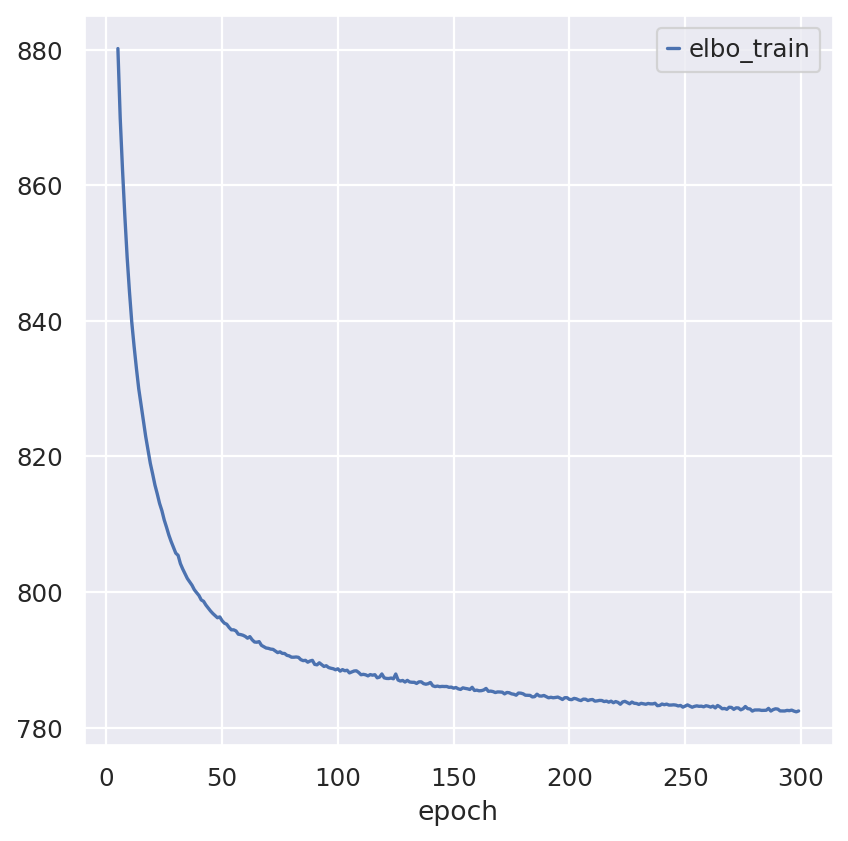

In [17]:
sc_model.history["elbo_train"].iloc[5:].plot()
plt.show()

Note that model converges quickly. Over experimentation with the model drastically reducing the number of epochs leads to decreased performance and performance deteriorates as max_epochs\<200.

## Deconvolution with stLVM

As a second step, we train our deconvolution model: spatial transcriptomics Latent Variable Model (stLVM).
We setup the DestVI model using the `counts` layer in `st_adata` that contains the raw counts. We then pass the trained `CondSCVI` model and generate a new model based on `st_adata` and `sc_model` using `DestVI.from_rna_model`.

In [18]:
# Deconvolution with stLVM
st_adata = st_adata[st_adata.layers["counts"].sum(1) > 10].copy()
st_adata.obs["batch"] = "spatial"


def spatial_nn_gex_smth(stadata, n_neighs):
    sc.pp.neighbors(stadata, n_neighs, use_rep="spatial", key_added="Xspatial")
    stadata.obsp["Xspatial_connectivities"] = stadata.obsp["Xspatial_connectivities"].ceil()
    stadata.obsp["Xspatial_connectivities"].setdiag(1)
    return stadata.obsp["Xspatial_connectivities"].dot(stadata.layers["counts"])


st_adata.layers["smoothed"] = spatial_nn_gex_smth(st_adata, n_neighs=5)

The decoder network architecture will be generated from `sc_model`. Two neural networks are initiated for cell type proportions and gamma value amortization. Training will take around 5 minutes in a Colab GPU session.

Potential adaptations of `DestVI.from_rna_model` are:

1. increasing `vamp_prior_p` leads to less gradual changes in gamma values
1. more discretized values. Increasing `l1_sparsity` will lead to sparser results for cell type proportions.
1. Although we recommend using similar sequencing technology for both assays, consider changing `beta_weighting_prior` otherwise.

Technical Note: During inference, we adopt a variational mixture of posterior as a prior to enforce gamma values in stLVM match scLVM (see details in original publication). This empirical prior is based on cell type specific subclustering (using k-means to find `vamp_prior_p` clusters) of the posterior distribution in latent space for every cell.

In [19]:
st_model = DestVI.from_rna_model(
    st_adata,
    sc_model,
    add_celltypes=2,
    n_latent_amortization=None,
    anndata_setup_kwargs={"smoothed_layer": "smoothed"},
)
st_model.view_anndata_setup()

Anndata setup with scvi-tools version 1.4.0.post1.

Setup via `DestVI.setup_anndata` with arguments:

{'layer': 'counts', 'smoothed_layer': 'smoothed', 'batch_key': 'batch'}

     Summary Statistics     
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Summary Stat Key ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│     n_batch      │   5   │
│     n_cells      │ 1092  │
│      n_vars      │ 1888  │
│   n_x_smoothed   │ 1888  │
└──────────────────┴───────┘

               Data Registry               
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃   scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │  adata.layers['counts']  │
│    batch     │ adata.obs['_scvi_batch'] │
│    ind_x     │  adata.obs['_indices']   │
│  x_smoothed  │ adata.layers['smoothed'] │
└──────────────┴──────────────────────────┘

                  batch State Registry                   
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃  Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch'] │     0      │          0          │
│                    │     1      │          1          │
│                    │     2      │          2          │
│                    │     3      │          3          │
│                    │  spatial   │          4          │
└────────────────────┴────────────┴─────────────────────┘

In [20]:
st_model.train(max_epochs=2500)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/access/.conda/envs/scvi/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.
/home/access/.conda/envs/scvi/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (9) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training:   0%|          | 0/2500 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=2500` reached.


Note that model converges quickly. Over experimentation with the model drastically reducing the number of epochs leads to decreased performance and we advocate against max_epochs\<1000.

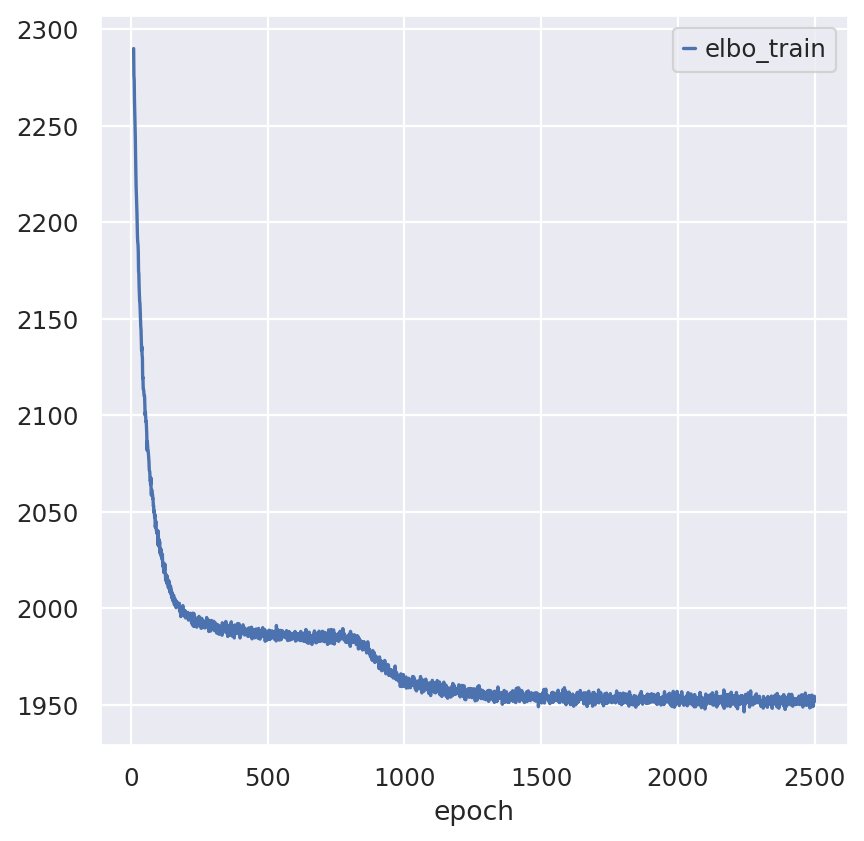

In [21]:
st_model.history["elbo_train"].iloc[10:].plot()
plt.show()

The output of DestVI has two resolution. At the broader resolution, DestVI returns the cell type proportion in every spot. At the more granular resolution, DestVI can impute cell type specific gene expression in every spot.

## Cell type proportions

We extract the computed cell type proportions and display them in spatial embedding. These values are directly calculated by normalized the spot-level parameters from the stLVM model.

In [22]:
st_adata.obsm["proportions"] = st_model.get_proportions()

In [23]:
st_adata.obsm["proportions"].head(5)

B cells  CD4 T cells  CD8 T cells  GD T cells  \
AAACCGGGTAGGTACC-1-0  0.614641     0.006973     0.098060    0.008689   
AAACCTCATGAAGTTG-1-0  0.624894     0.032680     0.036796    0.027864   
AAAGACTGGGCGCTTT-1-0  0.579505     0.035993     0.072657    0.009243   
AAAGGGCAGCTTGAAT-1-0  0.132107     0.051987     0.341011    0.036049   
AAAGTCGACCCTCAGT-1-0  0.800040     0.031249     0.003172    0.023120   

                      Macrophages  Migratory DCs  Monocytes  NK cells  \
AAACCGGGTAGGTACC-1-0     0.048782       0.025055   0.063510  0.000983   
AAACCTCATGAAGTTG-1-0     0.027050       0.051196   0.048278  0.001305   
AAAGACTGGGCGCTTT-1-0     0.043479       0.072511   0.016074  0.003305   
AAAGGGCAGCTTGAAT-1-0     0.057761       0.136065   0.052625  0.006519   
AAAGTCGACCCTCAGT-1-0     0.040634       0.016293   0.020085  0.001624   

                         Tregs     cDC1s     cDC2s      pDCs  
AAACCGGGTAGGTACC-1-0  0.035803  0.068723  0.014580  0.014202  
AAACCTCATGAAGTTG-1-0  0.080490  0.053341  0.011157  0.004949  
AAAGACTGGGCGCTTT-1-0  0.082376  0.054332  0.021667  0.008858  
AAAGGGCAGCTTGAAT-1-0  0.122469  0.047471  0.010136  0.005799  
AAAGTCGACCCTCAGT-1-0  0.014471  0.044327  0.003878  0.001108

In [24]:
ct_list = ["B cells", "CD8 T cells", "Monocytes"]
for ct in ct_list:
    data = st_adata.obsm["proportions"][ct].values
    st_adata.obs[ct] = np.clip(data, 0, np.quantile(data, 0.99))

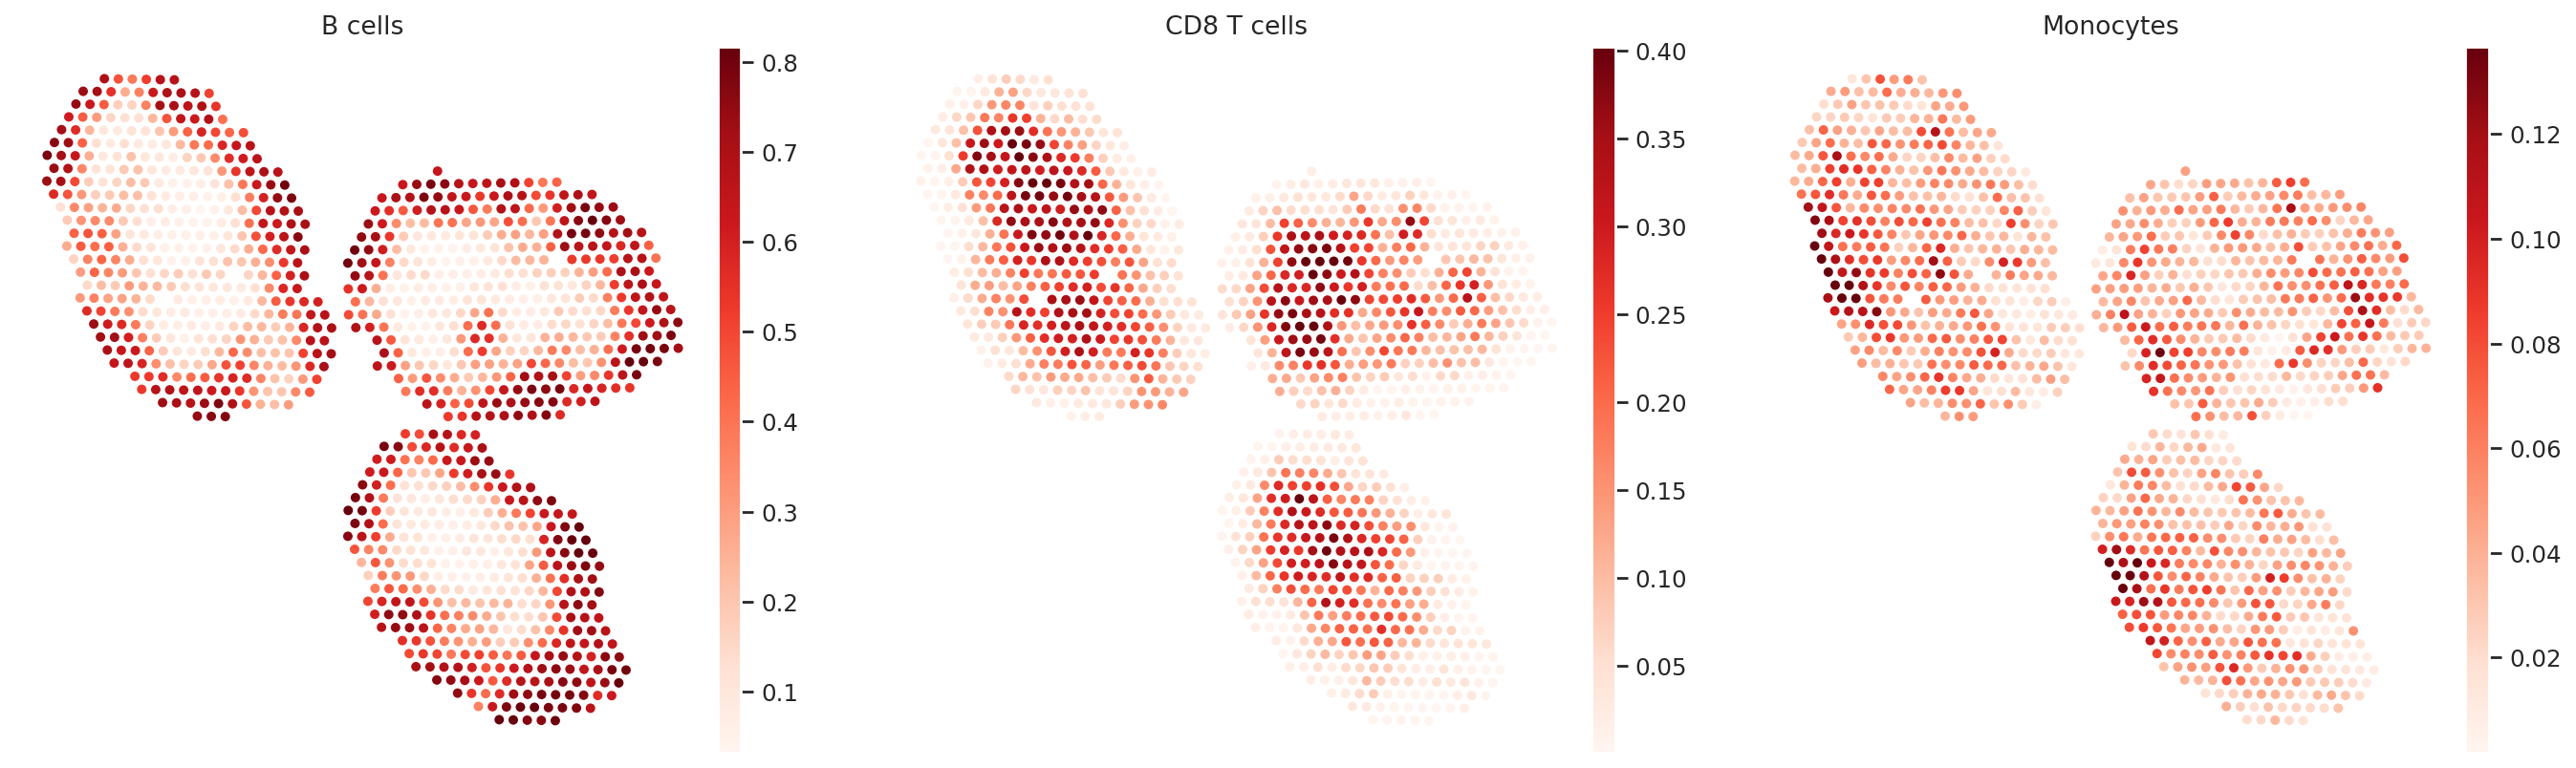

In [25]:
sc.pl.embedding(st_adata, basis="spatial", color=ct_list, cmap="Reds", s=80)

Because the inference of cell type specific gene expression is prone to error when the cell type is not present in a spot, and because the cell type proportion values estimated by stLVM are not sparse, we provide an automated way of thresholding them. For follow-up analysis we recommend checking these threshold values and adjust them for each cell type.

This part of the software is not directly available in scvi-tools, but instead in the util package `destvi_utils` (installable from GitHub; refer to the top of this tutorial).

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 452.40it/s]


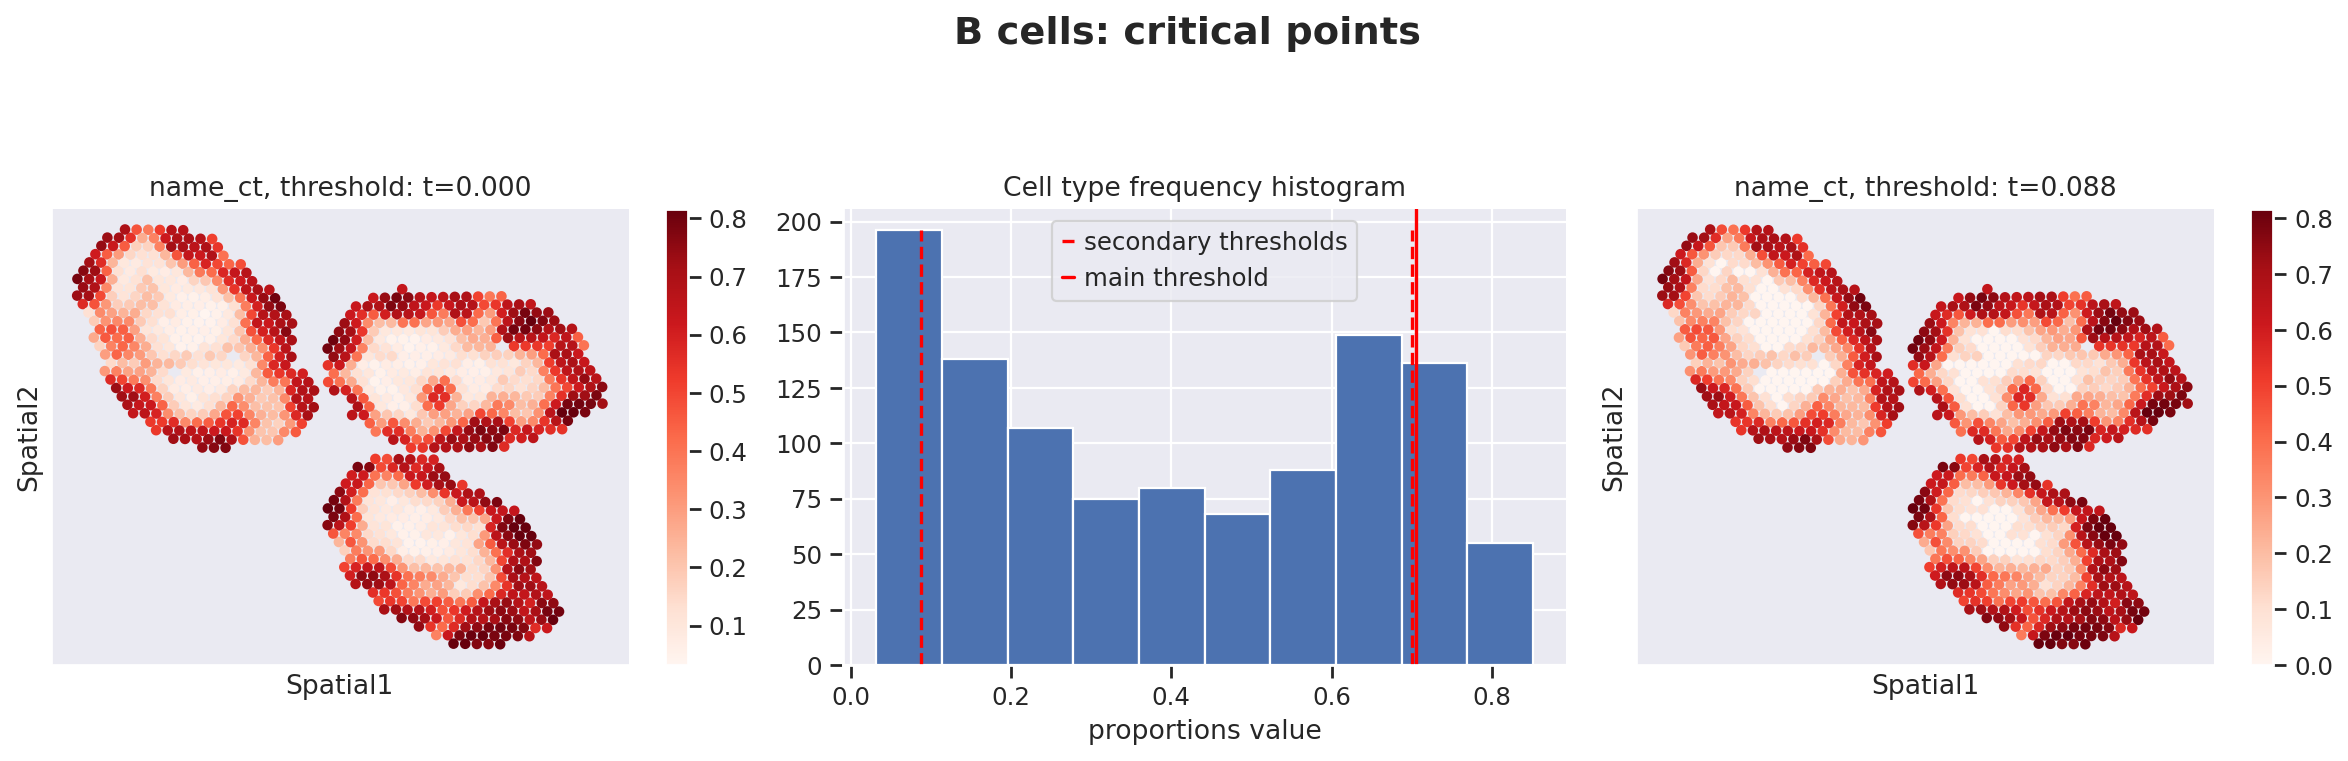

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 42149.57it/s]


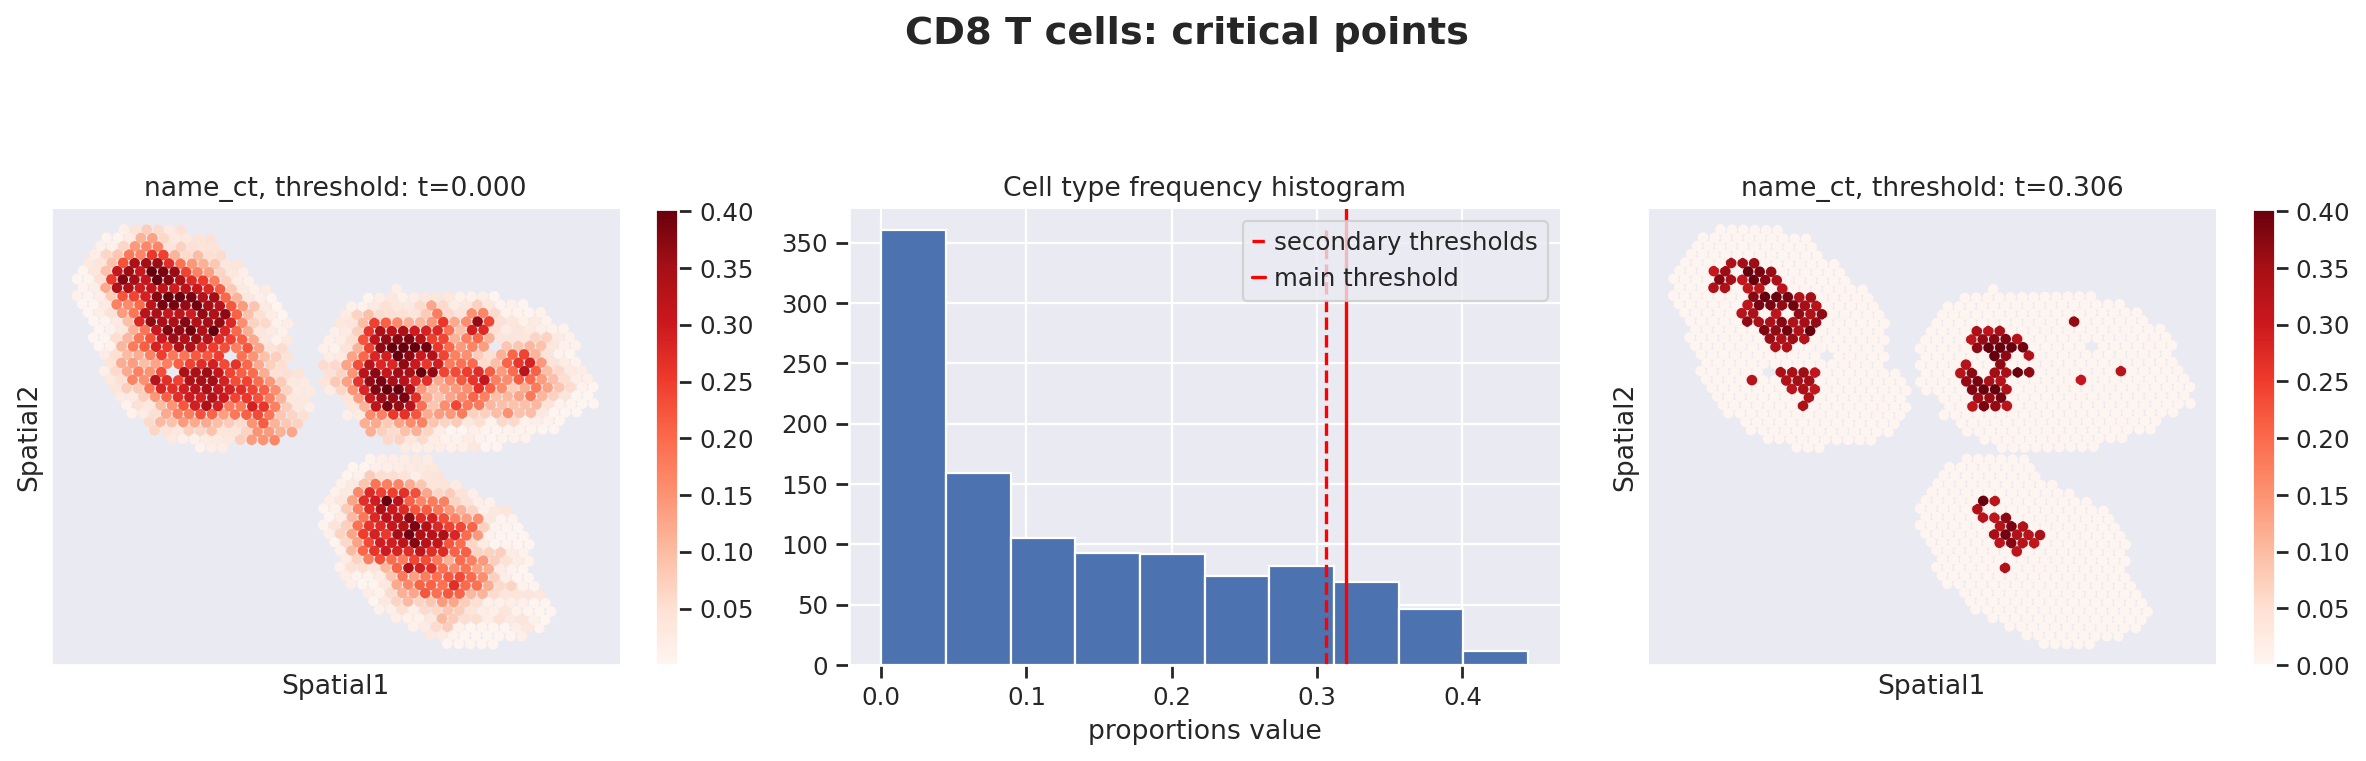

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 53478.31it/s]


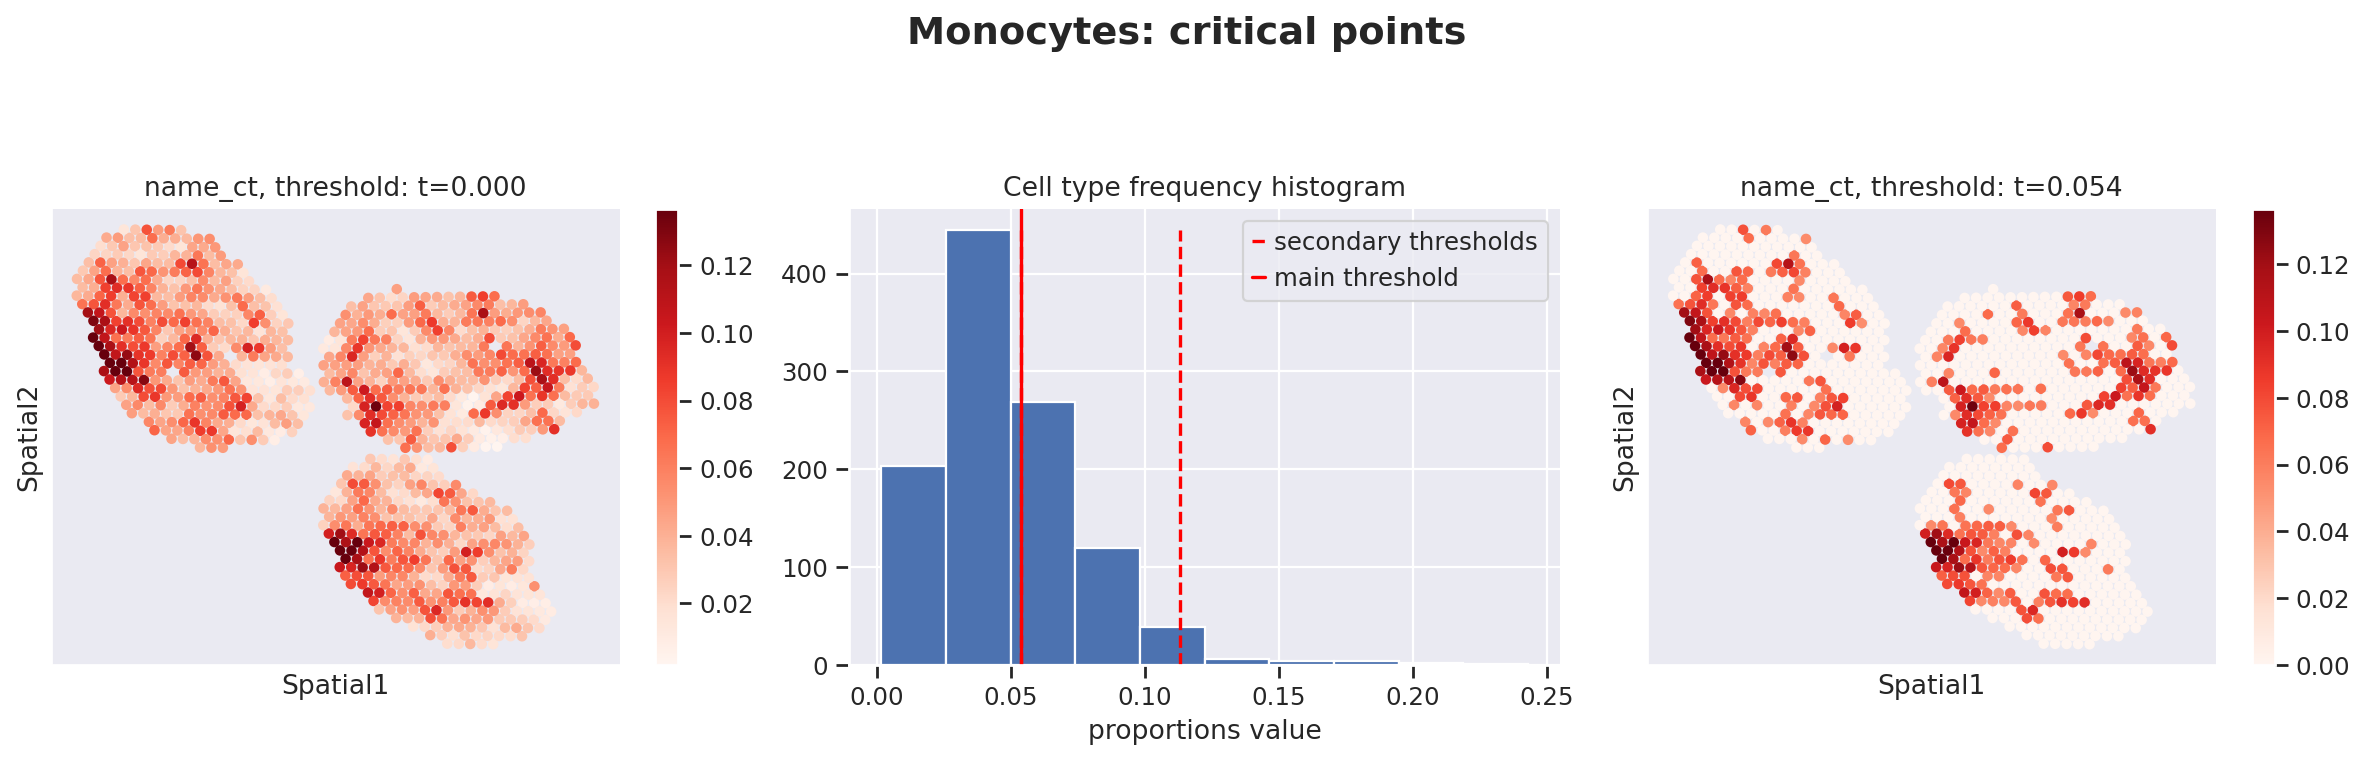

In [26]:
ct_thresholds = destvi_utils.automatic_proportion_threshold(
    st_adata, ct_list=ct_list, kind_threshold="secondary"
)

In terms of cell type location, we observe a strong compartimentalization of the cell types in the lymph node (B cells / T cells), as expected. We also observe a differential localization of the monocytes (refer to the paper for further details).

## Intra cell type information

At the heart of DestVI is a multitude of latent variables (5 per cell type per spots). We refer to them as "gamma", and we may manually examine them for downstream analysis

In [27]:
# more globally, the values of the gamma are all summarized in this dictionary of data frames
for ct, g in st_model.get_gamma().items():
    st_adata.obsm[f"{ct}_gamma"] = g

In [28]:
st_adata.obsm["B cells_gamma"].head(5)

0         1         2         3         4
AAACCGGGTAGGTACC-1-0 -0.410134  1.030277  0.237501 -1.026590  1.051770
AAACCTCATGAAGTTG-1-0 -0.642952 -0.490571 -0.022413 -1.613379  1.791276
AAAGACTGGGCGCTTT-1-0  1.064511 -0.198011  0.627033 -0.703501  0.266513
AAAGGGCAGCTTGAAT-1-0  0.860621 -1.091041  0.325320 -0.862027  0.803120
AAAGTCGACCCTCAGT-1-0 -0.488064  0.065028  0.105294 -1.113445  1.739760

Because those values may be hard to examine manually for end-users, we presented in the manuscript several methods for prioritizing the study of different cell types (based on spatially-weighted PCA and Hotspot). Below we provide the result of our automated pipeline with the spatially-weighted PCA.

More precisely, for de novo detection of spatial patterns, we study the gamma space and use a spatially-informed PCA to find the spatial axis of variation in this gamma space. We use EnrichR to functionally annotate these genes. In particular, we recover enrichment of IFN genes across monocytes as well as B cells

The function `explore_gamma_space` operates as follow, for each cell type individually:

1. Select all the spots with proportions beyond the magnitude threshold,
1. Calculate the spot-specific cell-type-specific embeddings gamma,
1. Calculate the first two principal vectors of those gamma values, weighted by the spatial coordinates,
1. Project all the embeddings (considered spots, and single-cell profiles) onto this 2D space,
1. Map each spot (or cell) to a specific color via its 2d coordinate, using the `cmap2d` package
1. Plot (A) the color of every spot in spatial coordinates (B) the color of every spot in sPC space (C) the color of every single cell in sPC space
1. Calculate genes enriched in each direction and group into pathways with `EnrichR`

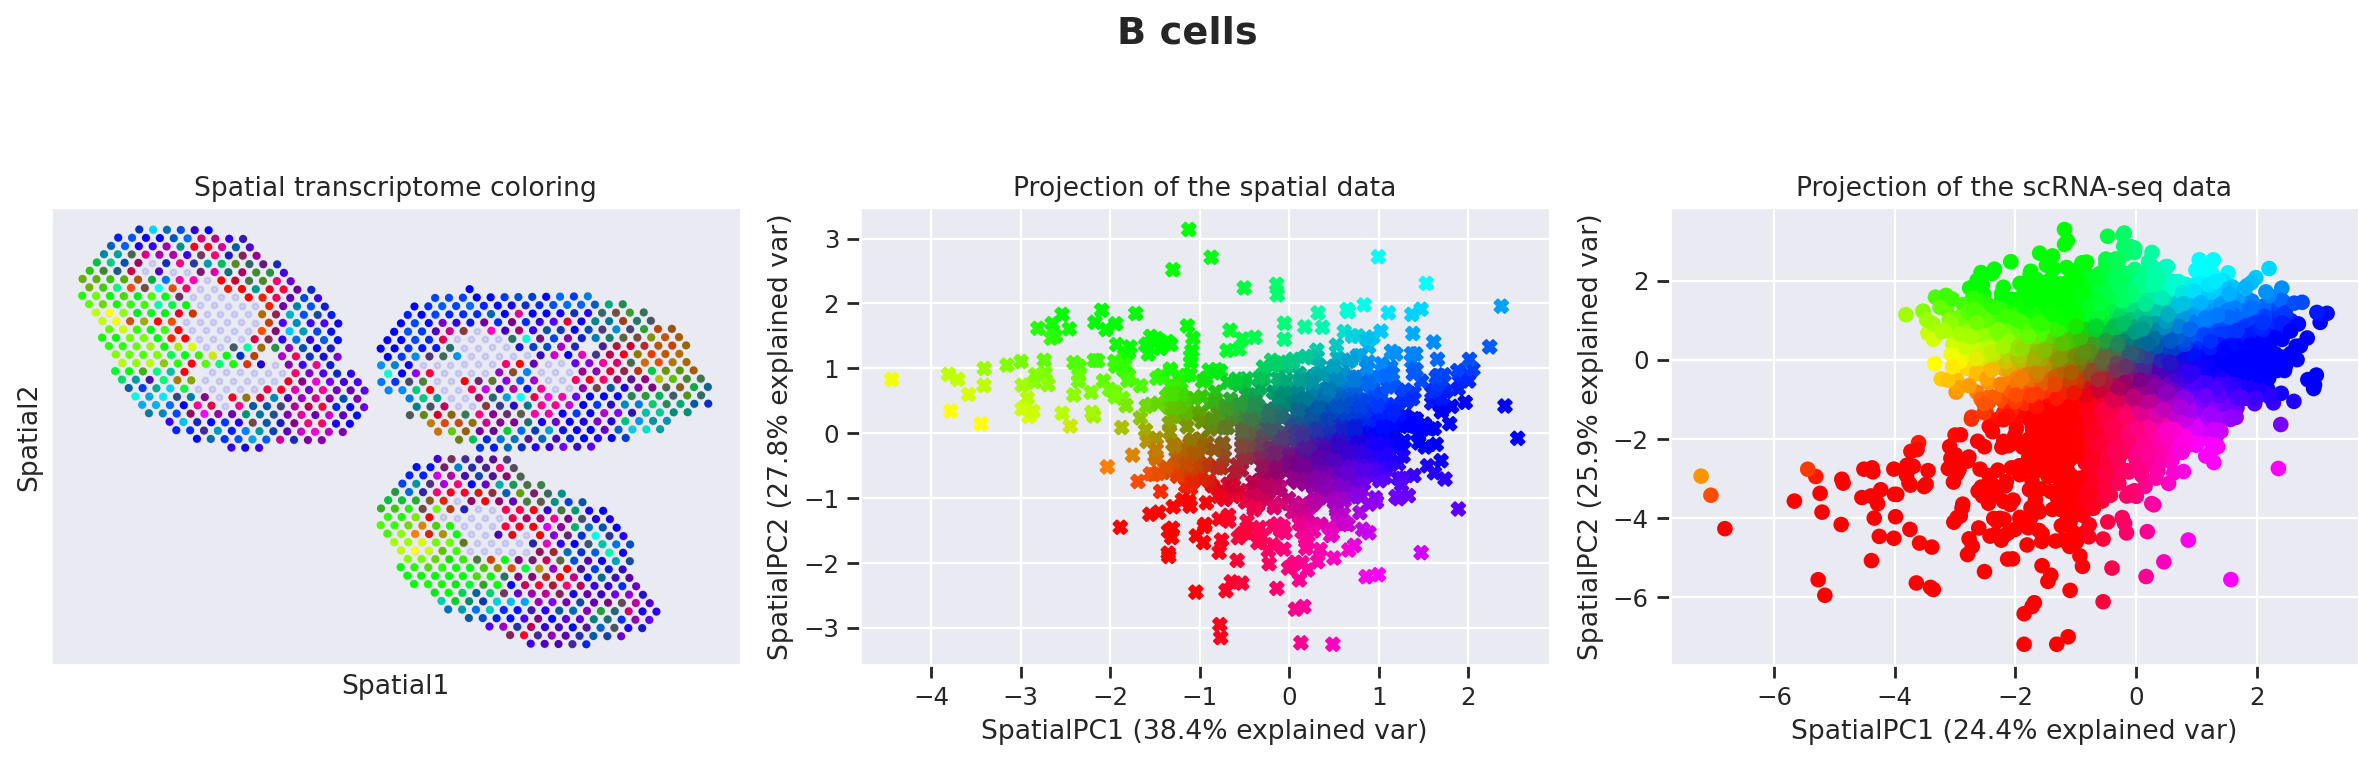

Genes associated with SpatialPC1

Positively

---------------------------------------------------------------------------------------

Cd74, H2-Aa, H2-Eb1, Cd79a, H2-Ab1, Fth1, Mef2c, Fcer2a, Fcmr, Iglc2, Igkc, Ighm, Rpsa, Ly6d, Tmsb4x, Vpreb3, 
Iglc3, Junb, Ftl1, Rplp1, Fcrla, Apoe, Chchd10, Ctsh, S100a10, Srgn, Fos, Ms4a1, Napsa, Pxdc1, H2-DMb1, Cd81, 
Gm26532, Lsp1, Plekho1, Serpinb1a, Mzb1, Rpl41, Gm42418, Cd200, Crip1, Cst3, Hexb, Fcgrt, Plk2, Gsn, Gpr183, Ciita,
Dusp1, Sfn

---------------------------------------------------------------------------------------

Antigen-activated B-cell receptor generation of second messengers*, BDNF signaling pathway*, Immune system*, 
Immunoregulatory interactions between a lymphoid and a non-lymphoid cell*, Adaptive immune system*, Signaling by 
the B cell receptor (BCR)*, TSH regulation of gene expression*, T cell receptor regulation of apoptosis*, ERBB1 
downstream pathway*, Wnt interactions in lipid metabolism and immune response*

Negatively

---------------------------------------------------------------------------------------

Stat1, Ifit3, Zbp1, Ifi47, Rtp4, Isg15, Irf7, Trim30a, Usp18, Slfn5, Ifit3b, Bst2, Ifit1, Igtp, Phf11b, Mki67, 
Gbp7, Birc5, Ifit2, Ccna2, Kif11, Parp14, Rnf213, Tpx2, Nusap1, Oas3, Rrm2, Hmmr, Rsad2, Eif2ak2, Gbp4, Esco2, 
Ncapg, Isg20, Ube2c, Oasl2, Kif4, Cdca3, Lgals3bp, Cdk1, Hist1h3c, Cdca5, Ccnb2, Cenpf, Serpina3g, E2f8, Rad51ap1, 
Plk1, Kif22, Bub1

---------------------------------------------------------------------------------------

Interferon signaling*, Interferon alpha/beta signaling*, Immune system signaling by interferons, interleukins, 
prolactin, and growth hormones*, Immune system*, FOXM1 transcription factor network*, Cyclin A/B1-associated events
during G2/M transition*, Antiviral mechanism by interferon-stimulated genes*, Cell cycle*, Progesterone-mediated 
oocyte maturation*, Interferon-gamma signaling pathway*

Genes associated with SpatialPC2

Positively

---------------------------------------------------------------------------------------

Cd79a, H2-Eb1, Cd74, H2-Aa, H2-Ab1, Ighm, Ly6d, Malat1, Ms4a1, Mef2c, Fth1, Iglc3, Igkc, Iglc2, Fcer2a, Fcmr, 
Rnase6, Fcrla, Ctsh, Mzb1, Vpreb3, Itm2b, Gm42418, Napsa, Ifit3, Slfn5, Ly86, Serpinb1a, Bcl11a, Srgn, Cd38, Jun, 
Irf7, Cst3, Ifi27l2a, Tspo, Crip1, Hspa1b, Pkib, Ly6a, Lsp1, Oasl2, Fcgrt, Icosl, Unc93b1, B2m, Ciita, Rtp4, Hexb, 
Hist1h1c

---------------------------------------------------------------------------------------

Immune system*, Antigen-activated B-cell receptor generation of second messengers*, Innate immune system*, 
Signaling by the B cell receptor (BCR)*, Toll receptor cascades*, Antigen processing and presentation*, Adaptive 
immune system*, Immunoregulatory interactions between a lymphoid and a non-lymphoid cell*, Amyloids*, Interferon 
signaling

Negatively

---------------------------------------------------------------------------------------

Birc5, Ccna2, Ube2c, Tpx2, Rrm2, Cdk1, Ccnb2, Mki67, Cdca3, Kif11, Hmmr, Ncapg, Bub1, Plk1, Cks1b, Uhrf1, Cdca8, 
Kif4, Ncaph, Ccnb1, Cdkn3, Kif2c, Hist1h3c, Ppp1r14b, Pbk, Spc24, Ska1, Kif22, Tyms, Neil3, Melk, Esco2, Dctpp1, 
Prc1, Cenpf, Cdca5, Top2a, Srm, Bzw2, Nuf2, Kif20a, E2f8, Cdca2, Cep55, Kif15, Mxd3, Lcp2, Nusap1, Nme1, Stmn1

---------------------------------------------------------------------------------------

Cell cycle*, M phase pathway*, Aurora B signaling*, FOXM1 transcription factor network*, Polo-like kinase 1 (PLK1) 
pathway*, DNA replication*, Cyclin A/B1-associated events during G2/M transition*, Kinesins*, Mitotic G1-G1/S 
phases*, Mitotic prometaphase*

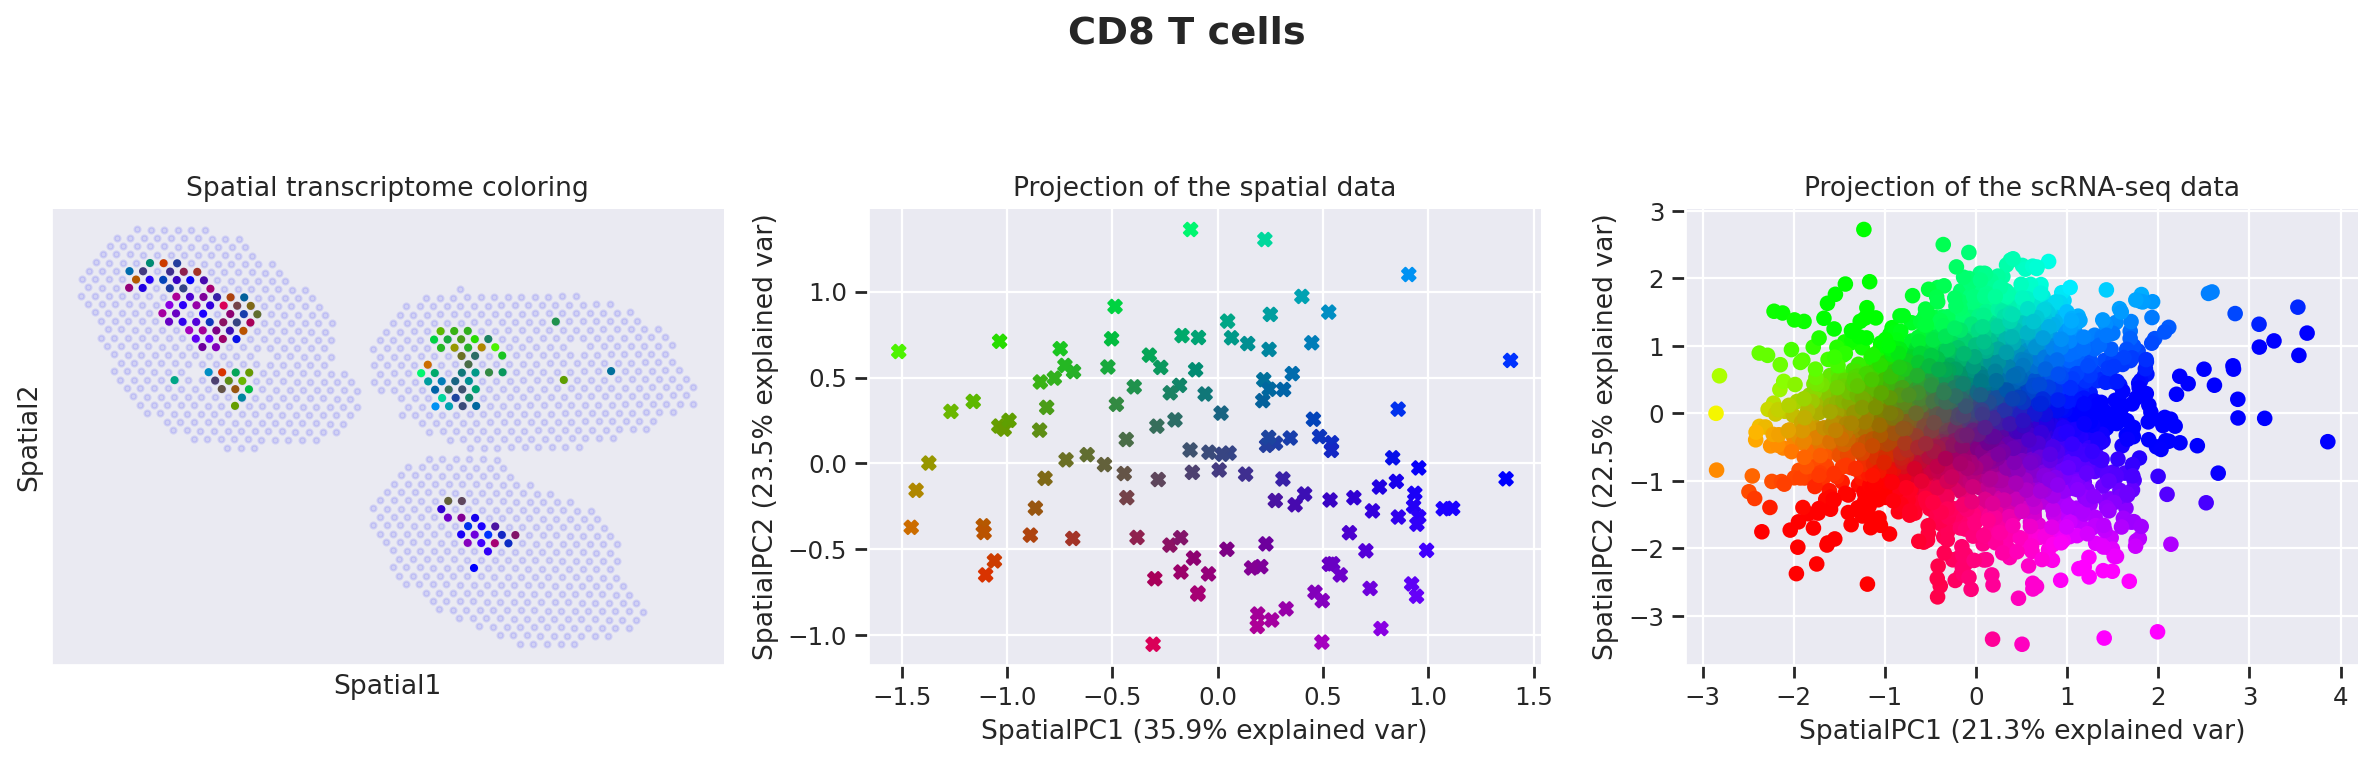

Genes associated with SpatialPC1

Positively

---------------------------------------------------------------------------------------

Ccl5, Ly6c2, Ifit3, Ctla2a, Xcl1, S100a6, Klrc2, Samd3, Cxcr3, Ms4a4c, Il18rap, Oasl2, Ccr5, Klrk1, Klre1, Klrc1, 
Ifit1, Irf7, 1700025G04Rik, Isg15, Rsad2, Slamf7, Dennd4a, Eomes, Serpina3g, Rtp4, Trim30a, Fcer1g, Gbp7, Ifngr1, 
Gbp4, Lrrk1, Il18r1, Ly6a, Il2rb, Usp18, Ifit3b, Zbp1, Plek, Igtp, AW112010, Parp14, Cd44, Gbp2, Sidt1, Herc6, 
Ctla2b, Gzmm, Klra7, Oas3

---------------------------------------------------------------------------------------

Interferon signaling*, Immune system signaling by interferons, interleukins, prolactin, and growth hormones*, 
Interferon alpha/beta signaling*, Interferon-gamma signaling pathway*, Immune system*, Interleukin-2 signaling 
pathway*, Cytokine-cytokine receptor interaction*, Selective expression of chemokine receptors during T-cell 
polarization*, Interleukin-12-mediated signaling events*, Interleukin-12/STAT4 pathway*

Negatively

---------------------------------------------------------------------------------------

Cd8b1, Ppia, Rgcc, Rplp0, Cd3g, Cd8a, Npc2, Ramp1, Rpl41, Rps2, Ccr9, Igfbp4, Rpsa, Lef1, Trac, Itgae, Rplp1, Cd3d,
Lat, Actn2, Actg1, Trbc2, Cd3e, Ptma, Actb, Nme2, Tubb5, Actn1, Eif4a1, Npm1, Inpp4b, Timp2, Tmsb4x, Dapl1, Ddit4, 
Thy1, Slc25a5, Dtx1, Plekho1, Ybx1, Rgs10, Cd226, Ftl1, Calm1, Sh3bp1, Ran, Lsp1, Gpr68, Cyb5a, Hnrnpa1

---------------------------------------------------------------------------------------

T helper cell surface molecules*, MEF2D role in T cell apoptosis*, Generation of second messenger molecules*, 
Interleukin-17 signaling pathway*, Disease*, T cell receptor signaling in naive CD8+ T cells*, Immunoregulatory 
interactions between a lymphoid and a non-lymphoid cell*, PD-1 signaling*, Adherens junction cell adhesion*, 
Arrhythmogenic right ventricular cardiomyopathy (ARVC)*

Genes associated with SpatialPC2

Positively

---------------------------------------------------------------------------------------

Ccl5, Ly6c2, Rpsa, Cxcr3, Ctla2a, Rps12, Samd3, Hopx, Xcl1, Gzmm, 1700025G04Rik, Rplp0, Il2rb, Rps2, Rplp1, Cd44, 
Ahnak, Ifitm10, Plek, Ifngr1, Sidt1, Il18rap, Ccr5, Klrd1, Ctla2b, Pglyrp1, Gpr183, S100a6, Il18r1, Il7r, Eomes, 
H2afz, Bbc3, Lrrk1, Rpl41, Klra7, Zyx, Runx2, Dennd4a, Klre1, Itgb1, Myo1f, Ccr2, Bcl2, Itm2a, Slamf7, Klrc2, Ccl4,
Ms4a4c, Klrc1

---------------------------------------------------------------------------------------

Interleukin-2 signaling pathway*, Cytokine-cytokine receptor interaction*, T cell receptor regulation of 
apoptosis*, Binding of chemokines to chemokine receptors*, Selective expression of chemokine receptors during 
T-cell polarization*, Cytoplasmic ribosomal proteins*, Leptin influence on immune response*, Ras-independent 
pathway in NK cell-mediated cytotoxicity*, Interleukin-12-mediated signaling events*, Influenza viral RNA 
transcription and replication*

Negatively

---------------------------------------------------------------------------------------

Isg15, Ifit1, Ccr9, Stat1, Zbp1, Ifit3, Iigp1, Slfn5, Ifi27l2a, Igtp, Isg20, Ramp1, Rgcc, Rtp4, Gbp2, Rsad2, 
Ifit3b, Gbp7, Oasl2, Usp18, Itgae, Gbp4, Malat1, Irf7, B2m, Gbp8, Parp14, Ifi47, Slfn1, Bst2, Rnf213, Ddx60, Cmpk2,
Oas3, Ly6a, Trim30a, Herc6, Cd3g, Igfbp4, Ifih1, Pmepa1, Cd274, Sox4, Trafd1, Eif2ak2, Actb, Lgals3bp, Phf11b, 
Art2b, Cd226

---------------------------------------------------------------------------------------

Interferon signaling*, Interferon alpha/beta signaling*, Immune system signaling by interferons, interleukins, 
prolactin, and growth hormones*, Immune system*, Interferon-gamma signaling pathway*, Antiviral mechanism by 
interferon-stimulated genes*, Type II interferon signaling (interferon-gamma)*, CTL mediated immune response 
against target cells, TRAF3-dependent IRF activation pathway, Interleukin-12-mediated signaling events

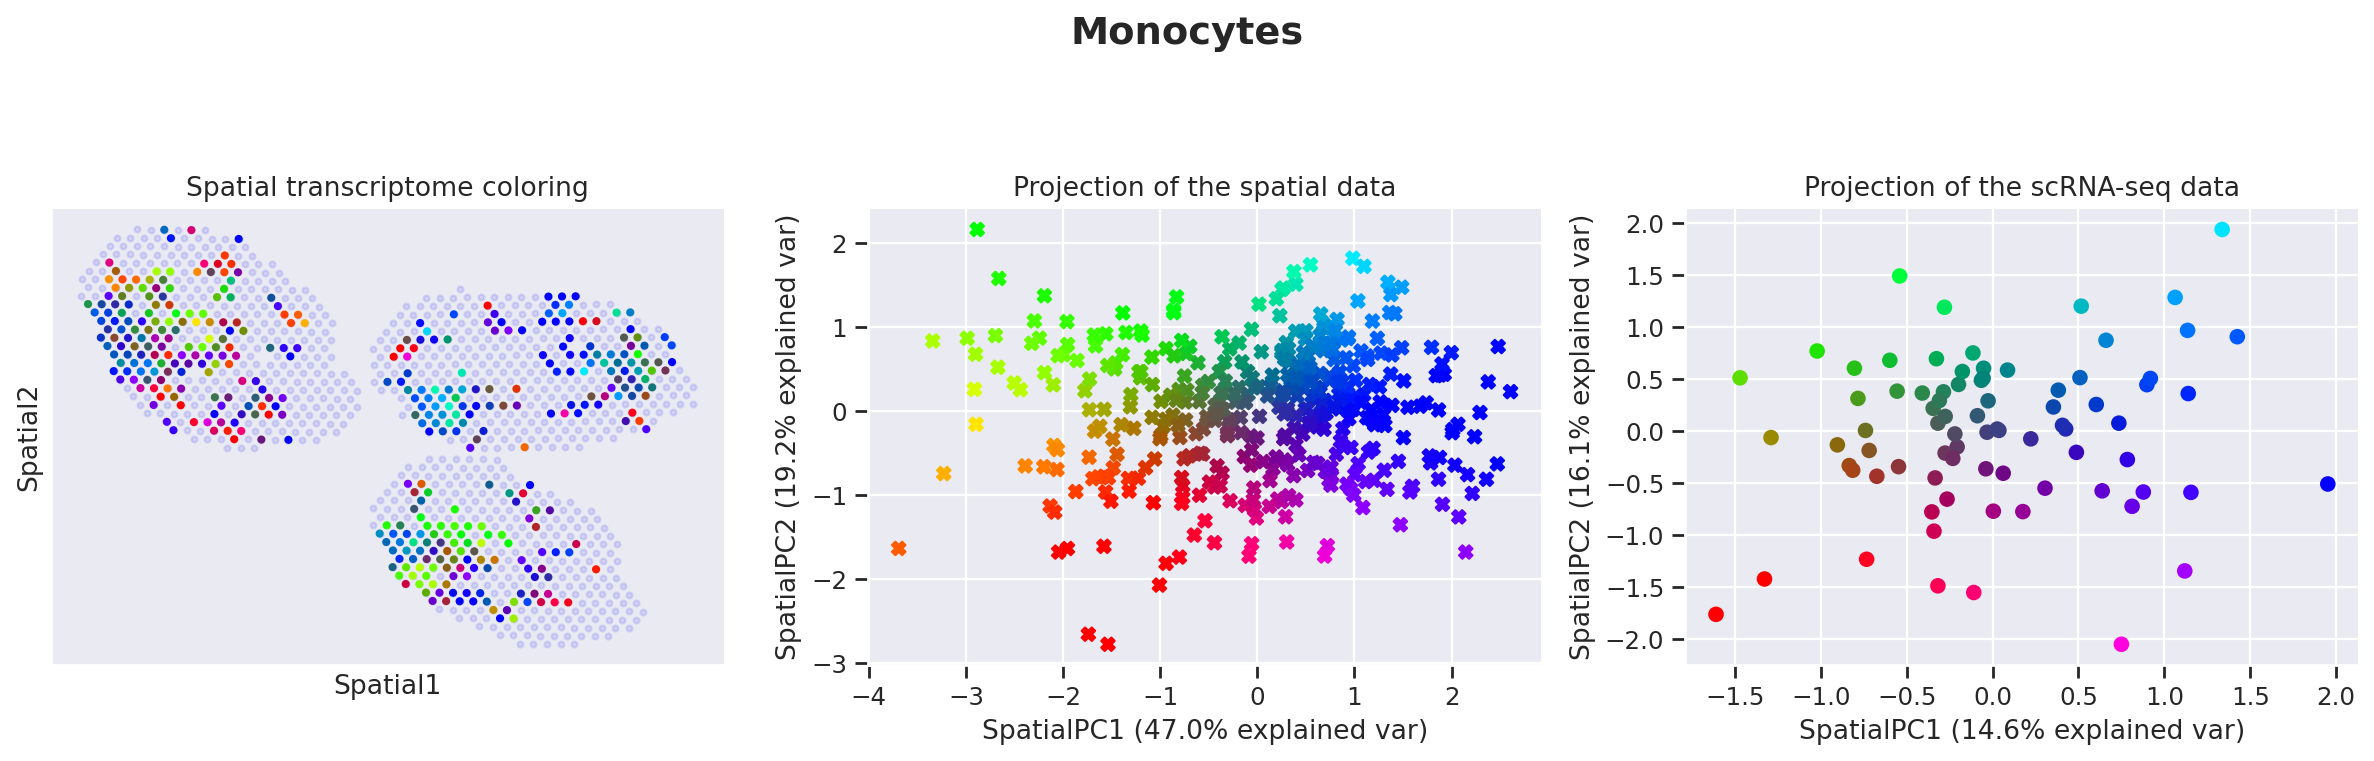

Genes associated with SpatialPC1

Positively

---------------------------------------------------------------------------------------

Tspan3, Sema7a, Cd63, Plxnc1, Fabp5, Dbf4, Ftsj3, Itgax, Mif, Nr4a3, Abcd2, Ehd1, Tarm1, Fcrl5, Vegfa, Hnrnpll, 
Hdgf, Plxna1, Fosb, Fosl2, Tuba1c, Ccdc88a, Itga8, Il1b, St3gal5, Rgs1, Fen1, Nrp2, Canx, Eprs, Rpl41, Hnrnpab, 
Sirpa, Rad21, Psrc1, Klra17, Klrb1b, Tuba1a, Bcl2l1, Dusp1, Ank, Cyfip1, Basp1, Gla, Ppia, Osm, Neat1, Gria3, 
Actn1, Inpp4b

---------------------------------------------------------------------------------------

Interleukin-2 signaling pathway*, Other semaphorin interactions*, EGFR1 pathway*, Response to elevated platelet 
cytosolic calcium*, Neurophilin interactions with VEGF and VEGF receptor*, Hemostasis pathway*, Signaling by VEGF, 
HIV life cycle early phase, Semaphorin interactions, AP-1 transcription factor network

Negatively

---------------------------------------------------------------------------------------

Ifi204, Ms4a6b, Ifit3, Plac8, Igtp, Ifi205, Fcgr1, Oasl2, Igkc, Ms4a4c, Sp140, Ifit3b, Ifi47, Flt1, Rtp4, Oas3, 
Zbp1, Gbp2, Nupr1, Scimp, Gnb4, Themis2, Ms4a1, Ms4a6d, Ifit1, Gbp7, Ccr2, Hivep3, Psme2, Irf1, Cxcl10, Rnf213, 
Iglc2, Cybb, Ctss, Arhgap31, Trafd1, Ly6d, Ly6c2, Ms4a6c, Ms4a4b, Slfn1, Bst2, Pou2af1, Ifit2, Lyz2, Cd24a, Isg20, 
Unc93b1, Vpreb3

---------------------------------------------------------------------------------------

Interferon alpha/beta signaling*, Immune system*, Interferon signaling*, Immune system signaling by interferons, 
interleukins, prolactin, and growth hormones*, Type II interferon signaling (interferon-gamma)*, Innate immune 
system*, Thymic stromal lymphopoietin (TSLP) pathway*, Interferon-gamma signaling pathway*, Toll-like receptor 
endosomal trafficking and processing*, Antigen processing: cross presentation

Genes associated with SpatialPC2

Positively

---------------------------------------------------------------------------------------

Glrx, Anpep, Klrk1, Fgl2, Ranbp1, Clic4, Cxcl9, Csrp1, Hells, Pnp, Isg15, Calm1, Cfb, Naaa, Mxd1, Cks1b, Pdk3, 
Mcm10, Spint1, Rps27l, Chaf1a, H2-DMb1, Il1rn, Hspa9, Evi2a, Cycs, Alyref, Cd40, Apex1, Efhd2, Psma4, Ccnd1, Sub1, 
Cdkn1a, Parp12, Slamf8, Tmpo, Ctsc, Gatm, Atpif1, Rfc4, Mvp, Slco3a1, Gapdh, Plekho2, Anxa4, E2f1, Mcm4, Ywhae, 
Lgals1

---------------------------------------------------------------------------------------

Mitotic G1-G1/S phases*, S phase*, Cell cycle*, T cell receptor regulation of apoptosis*, EGFR1 pathway*, Cyclin 
D-associated events in G1*, DNA replication pre-Initiation*, Cell cycle checkpoints*, DNA replication*, Glioma*

Negatively

---------------------------------------------------------------------------------------

Fcmr, Fcrla, Itgb5, Cx3cr1, Hfe, Pou2af1, Iglc3, Ms4a1, Mzb1, Igkc, Ifngr1, Iglc2, Blk, Cd79a, Gfra2, Ctsb, Csf1r, 
Ly75, Spn, Prkar1b, Itm2b, Myc, Ighm, Ly6d, Egr3, Ace, Vpreb3, Gm1673, Cd200, Tmem26, Mef2c, Zbtb20, Nrgn, Chek1, 
Ifng, Il1r1, 3830403N18Rik, Fcer2a, Msrb1, Myb, Mgst1, Tlr13, Slc8b1, Cacna1b, Klk8, Serpinb1a, Art2b, Cdkn2c, 
Hjurp, Gm5547

---------------------------------------------------------------------------------------

Antigen-activated B-cell receptor generation of second messengers*, Immune system*, Signaling by the B cell 
receptor (BCR)*, Adaptive immune system*, Inhibition of activated T cell apoptosis by neuropeptides VIP and PACAP*,
TSH regulation of gene expression*, T cell receptor regulation of apoptosis*, Interleukin-2 signaling pathway*, 
Immunoregulatory interactions between a lymphoid and a non-lymphoid cell*, Cytokine-cytokine receptor interaction

In [29]:
destvi_utils.explore_gamma_space(st_model, sc_model, ct_list=ct_list, ct_thresholds=ct_thresholds)

We anticipate this to be a valuable ressource for formulating scientific hypotheses from ST data.

## Example with B cells; and differential expression

First, we display the genes identified via the pipeline as well as Hotspot (see manuscript), using the B-cell-specific gene expression values imputed by DestVI.

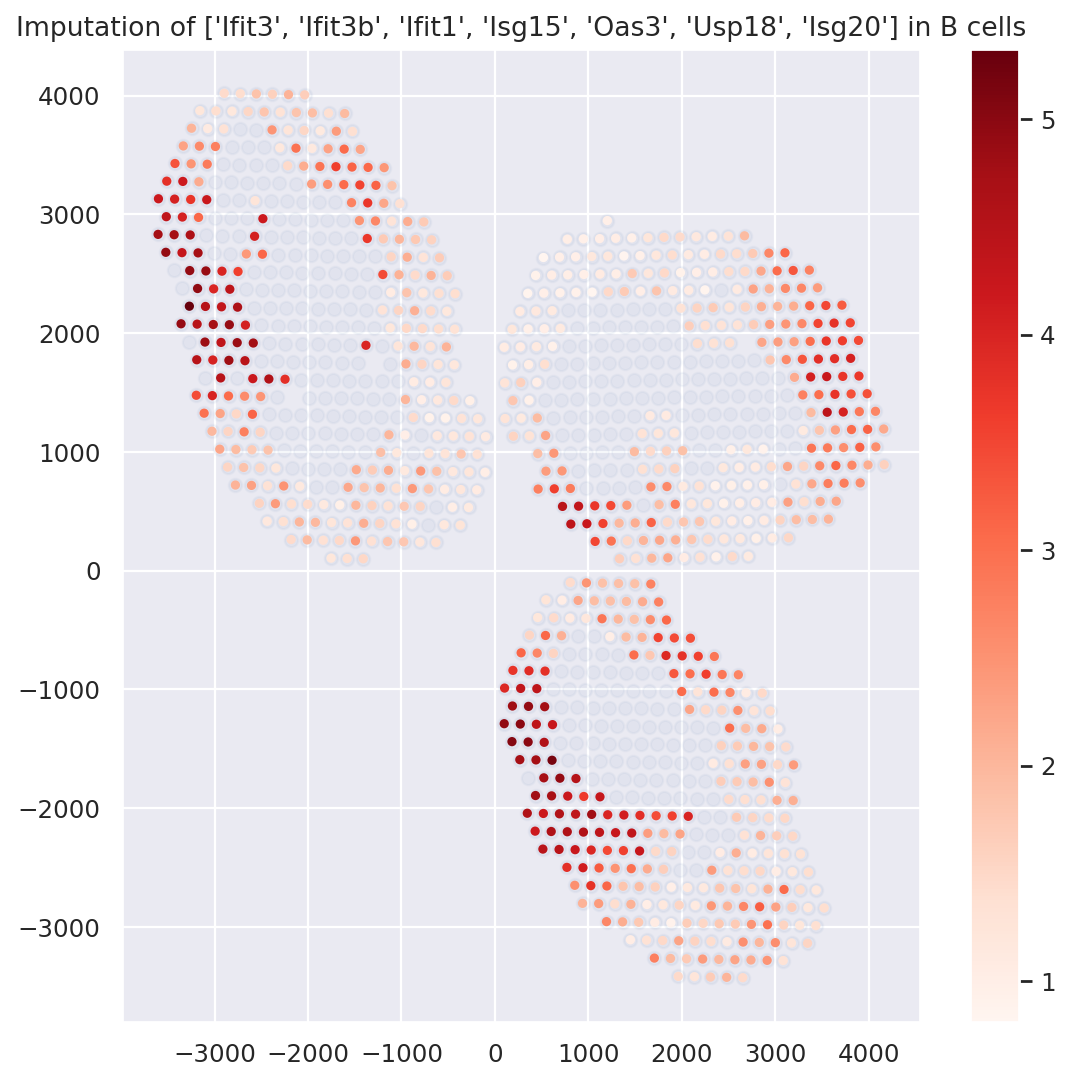

In [30]:
plt.figure(figsize=(8, 8))

ct_name = "B cells"
gene_name = ["Ifit3", "Ifit3b", "Ifit1", "Isg15", "Oas3", "Usp18", "Isg20"]

# we must filter spots with low abundance (consult the paper for an automatic procedure)
indices = np.where(st_adata.obsm["proportions"][ct_name].values > 0.2)[0]

# impute genes and combine them
specific_expression = np.sum(st_model.get_scale_for_ct(ct_name, indices=indices)[gene_name], 1)
specific_expression = np.log(1 + 1e4 * specific_expression)

# plot (i) background (ii) g
plt.scatter(st_adata.obsm["location"][:, 0], st_adata.obsm["location"][:, 1], alpha=0.05)
plt.scatter(
    st_adata.obsm["location"][indices][:, 0],
    st_adata.obsm["location"][indices][:, 1],
    c=specific_expression,
    s=10,
    cmap="Reds",
)
plt.colorbar()
plt.title(f"Imputation of {gene_name} in {ct_name}")
plt.show()

Second, we apply a Kolmogorov-Smirnov test on the generated counts to study the differential expression of B cells in the exposed lymph nodes, between the interfollicular area (IFA) and the rest. We display the identified IFN genes in a Volcano plot and see significant upregulation in the IFA area of exposed lymph nodes.

/home/access/.conda/envs/scvi/lib/python3.12/site-packages/destvi_utils/_destvi_utils.py:467: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  torch.distributions.Gamma(concentration=concentration[mask_], rate=rate)


log2FC     score  pval
Ifit1   4.032940  0.729527   0.0
Ifit3   4.342963  0.715804   0.0
Ifit2   3.490396  0.664848   0.0
Ifit3b  4.326105  0.602065   0.0
Slfn5   3.020566  0.593361   0.0
Ifitm3  3.304686  0.591831   0.0
Irf7    2.533088  0.550693   0.0
Oas3    3.037543  0.545928   0.0
Cmpk2   2.569157  0.542041   0.0
Isg15   3.052167  0.514476   0.0

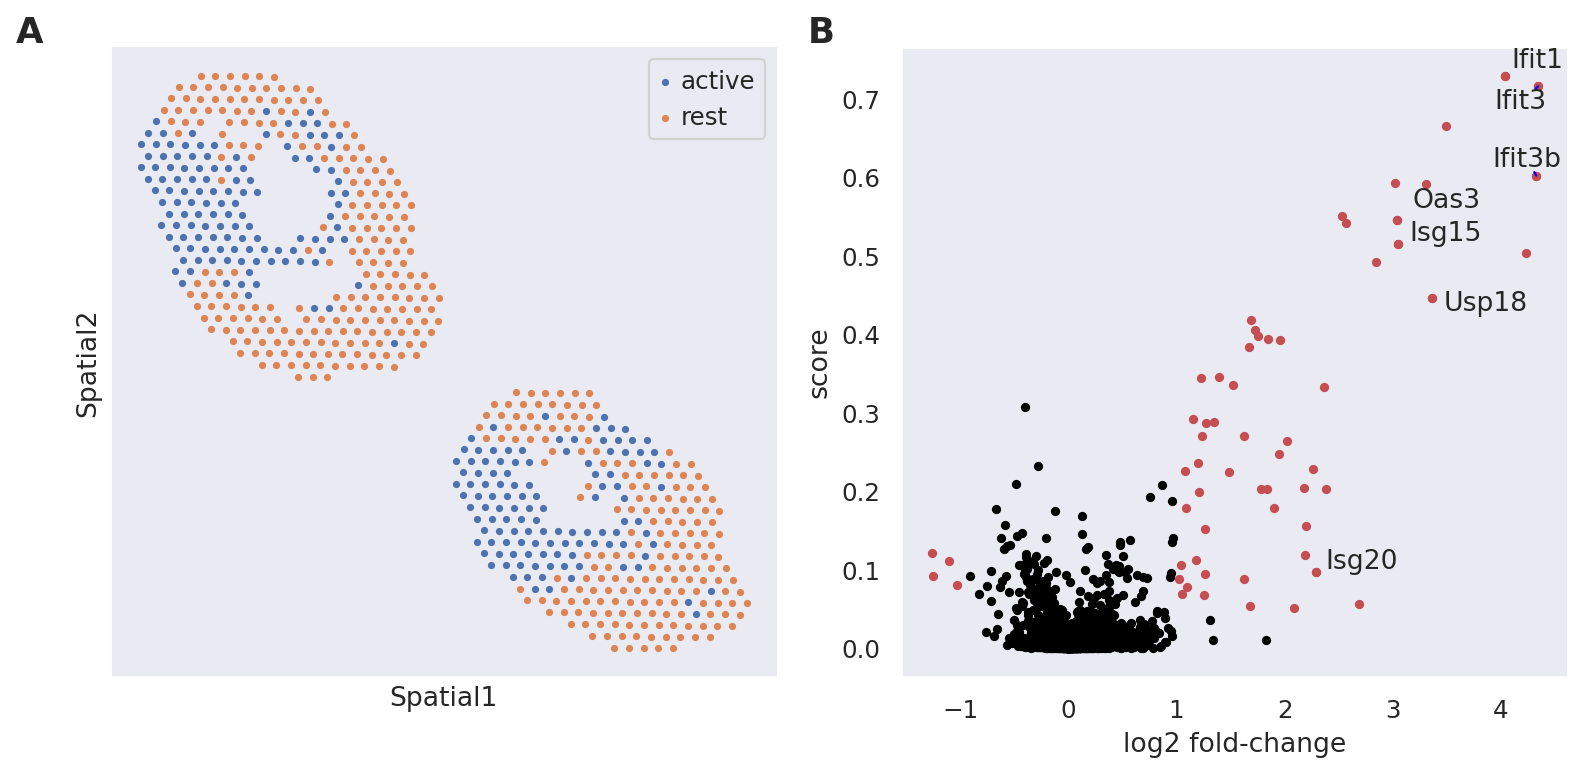

In [31]:
ct = "B cells"
imputation = st_model.get_scale_for_ct(ct)
color = np.log(1 + 1e5 * imputation["Ifit3"].values)
threshold = 4

mask = np.logical_and(
    np.logical_or(st_adata.obs["LN"] == "TC", st_adata.obs["LN"] == "BD"),
    color > threshold,
).values

mask2 = np.logical_and(
    np.logical_or(st_adata.obs["LN"] == "TC", st_adata.obs["LN"] == "BD"),
    color < threshold,
).values

_ = destvi_utils.de_genes(
    st_model, mask=mask, mask2=mask2, threshold=ct_thresholds[ct], ct=ct, key="IFN_rich"
)

display(st_adata.uns["IFN_rich"]["de_results"].head(10))

destvi_utils.plot_de_genes(
    st_adata,
    interesting_genes=["Ifit3", "Ifit3b", "Ifit1", "Isg15", "Oas3", "Usp18", "Isg20"],
    key="IFN_rich",
)